In [312]:
import pandas as pd
import numpy as np
import tensorflow as tf
from data_loader import load_veterans_ds, prepare_veterans_ds
from sklearn.preprocessing import StandardScaler
from utility import InputFunction, CindexMetric, CoxPHLoss, _make_riskset, _TFColor, sample_hmc, convert_to_structured
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import pickle
from sksurv.metrics import integrated_brier_score

TFColor = _TFColor()
dtype = tf.float32
number_burnin_steps = 5000

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

# Load data
X_train, X_valid, X_test, y_train, y_valid, y_test = load_veterans_ds()
t_train, t_valid, t_test, e_train, e_valid, e_test  = prepare_veterans_ds(y_train, y_valid, y_test)

# Load model chains
curr_dir = os.getcwd()
root_dir = Path(curr_dir).absolute().parent
with open(f'{root_dir}/models/mcmc_chains.pkl', 'rb') as fp:
    chains = pickle.load(fp)
    
# Make structured arrays
y_train_struc = convert_to_structured(t_train, e_train)
y_valid_struc = convert_to_structured(t_valid, e_valid)

iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.


In [313]:
# Save alpha and betas from chain at index 0
chain_index = 0
alpha_index = 0
beta_index = 1

samples = chains[chain_index]
alphas = samples.all_states[alpha_index].numpy().flatten()[number_burnin_steps:] # skip burnin steps
n_dims = chains[chain_index].all_states[beta_index].shape[2]
number_of_steps = chains[chain_index].all_states[beta_index].shape[0]

X_train = np.array(X_train)[:,:n_dims]
X_valid = np.array(X_valid)[:,:n_dims]
X_test = np.array(X_test)[:,:n_dims]

betas = np.zeros((n_dims, number_of_steps-number_burnin_steps))
for i in range(n_dims):
    betas[i] = samples.all_states[beta_index][:,:,i].numpy().flatten()[number_burnin_steps:]

print(alphas.mean())
for beta in betas:
    print(beta.mean())

3.8800774
0.17351000817120074


In [314]:
lambda_mean, lambda_std = np.exp(alphas.mean()), np.exp(alphas.std())
mean_obs_time = y_train[y_train['Status']==True]['Survival_in_days'].mean()
print(f"mean/std lambda: {np.around(float(lambda_mean), 2)} (+-{np.around(float(lambda_std), 2)})")
print(f"mean obs time: {mean_obs_time}")

mean/std lambda: 48.43 (+-1.01)
mean obs time: 124.51


In [315]:
mean_alpha = alphas.mean()
mean_betas = betas.mean(axis=1)

np.exp(mean_alpha + X_valid @ mean_betas)

array([ 6444630.86254153,  1913008.82293207,  2706611.0543769 ,
        6444630.86254153, 10845794.31659128,    21013.65299456,
         141709.9635971 ,  2706611.0543769 ,  3829435.23932474,
        2275471.56151609,  7665711.77110714,  2706611.0543769 ,
        4555008.25678128,  4555008.25678128])

In [316]:
# Make predictions on valid dataset (ignore the uncertainity)
mean_alpha = tf.math.reduce_mean(alphas, axis=0).numpy()
mean_betas = tf.math.reduce_mean(betas, axis=1).numpy()

predict_func = lambda data: np.exp(mean_alpha + np.dot(mean_betas, np.transpose(data)))

valid_preds = np.zeros((len(X_valid)))
for i, data in enumerate(X_valid):
    valid_preds[i] = predict_func(data)

In [317]:
t_valid

array([110.,   8., 153., 392.,  80.,   1., 117.,  12.,  31., 389., 151.,
        54.,   8., 177.])

In [318]:
valid_preds

array([ 6444630.86254153,  1913008.82293207,  2706611.0543769 ,
        6444630.86254153, 10845794.31659128,    21013.65299456,
         141709.9635971 ,  2706611.0543769 ,  3829435.23932474,
        2275471.56151609,  7665711.77110714,  2706611.0543769 ,
        4555008.25678128,  4555008.25678128])

In [319]:
# Calculate C-index using negative event times as risk
from sksurv.metrics import concordance_index_censored
results = concordance_index_censored(e_valid, t_valid, valid_preds)[0]
print(results)

0.38333333333333336


In [320]:
# Calculate Brier score
lower, upper = np.percentile(t_valid[t_valid.dtype.names], [10, 90])
times = np.arange(lower, upper+1)

estimate = np.zeros((len(X_valid), len(times)))
for i, data_obs in enumerate(X_valid):
    pred_lambda = predict_func(data)
    surv_prob = np.exp(-times/pred_lambda)
    estimate[i] = surv_prob

integrated_brier_score(y_train_struc, y_valid_struc, estimate, times)

0.7087374632457634

Text(0, 0.5, 'Density')

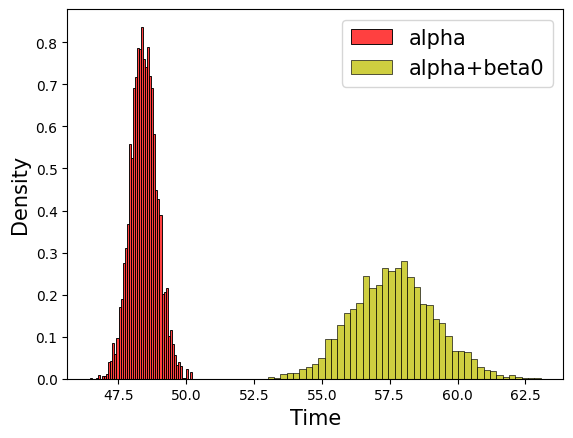

In [323]:
# Calculate log rate as log lambda = a+bX 
lambda_no_beta = np.exp(alphas)
lambda_beta0 = np.exp(alphas + betas[0])
#lambda_beta1 = np.exp(alphas + betas[1])
#lambda_beta2 = np.exp(alphas + betas[2])

# Plot distributions with various betas used. Notice the shift in risk (normalized)
sns.histplot(lambda_no_beta, color='r', stat='density', label='alpha')
sns.histplot(lambda_beta0, color='y', stat='density', label='alpha+beta0')
#sns.histplot(lambda_beta1, color='b', stat='density', label='alpha+beta1')
#sns.histplot(lambda_beta2, color='m', stat='density', label='alpha+beta2')
plt.legend(fontsize=15)
plt.xlabel("Time", size=15)
plt.ylabel("Density", size=15)

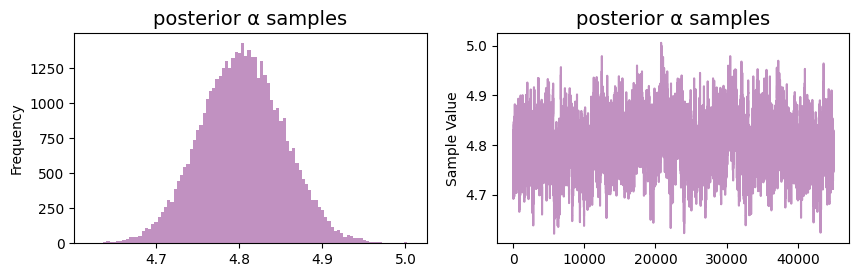

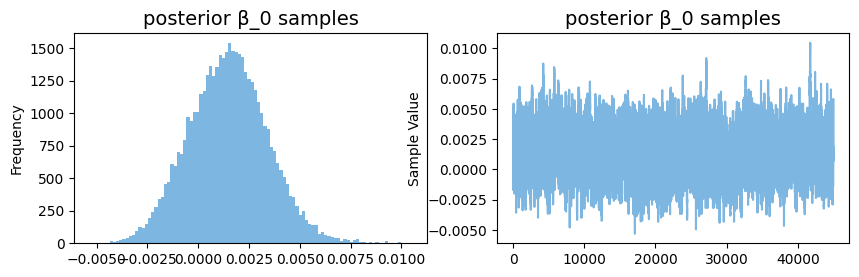

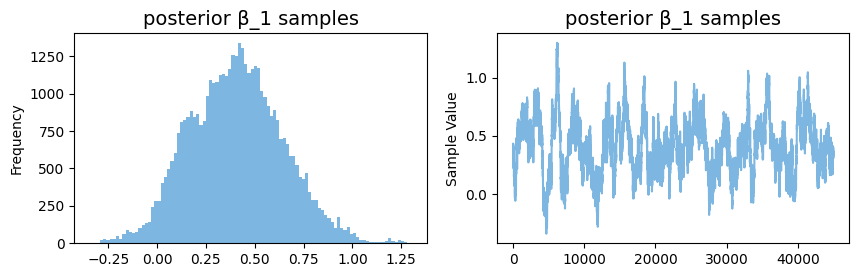

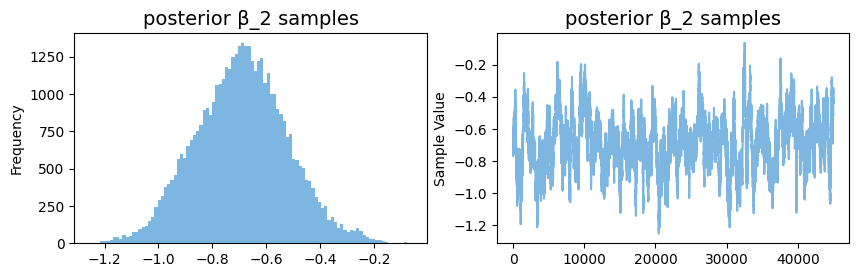

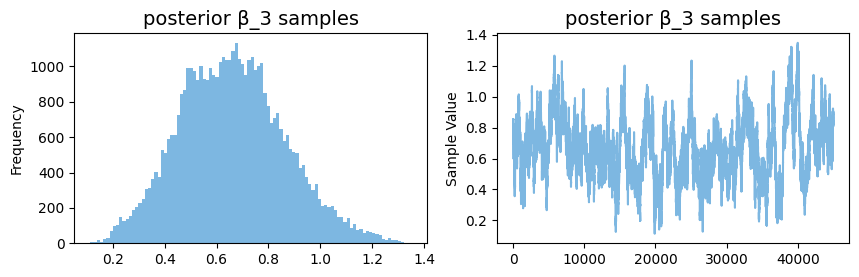

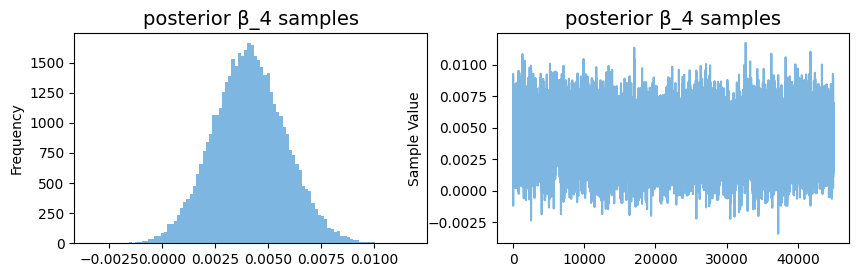

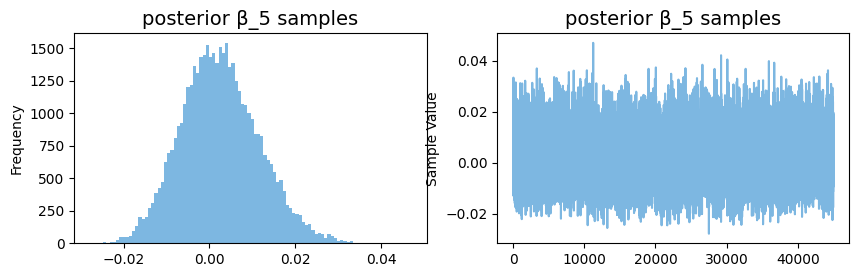

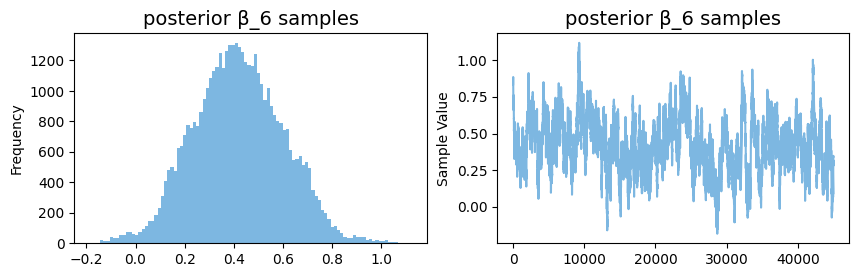

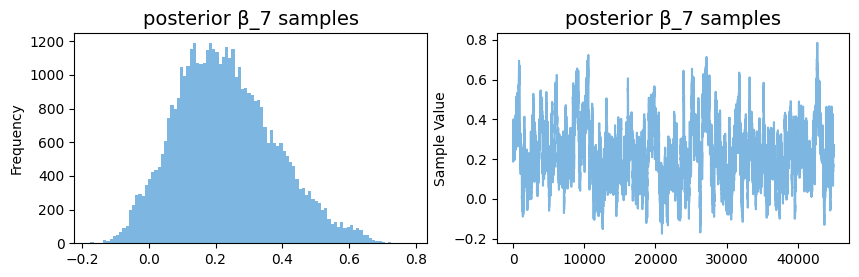

In [298]:
# Plot the posterior samples
 
plt.figure(figsize=(10,6))
plt.subplot(2, 2, 1)
plt.hist(alphas, bins=100, color=TFColor[6], alpha=0.8)
plt.ylabel('Frequency')
plt.title('posterior α samples', fontsize=14)

plt.subplot(2, 2, 2)
plt.plot(np.arange(number_of_steps-number_burnin_steps), alphas, color=TFColor[6], alpha=0.8)
plt.ylabel('Sample Value')
plt.title('posterior α samples', fontsize=14)

for i in range(n_dims):
    plt.figure(figsize=(10,6))
    plt.subplot(2, 2, 1)
    plt.hist(betas[i], bins=100, color=TFColor[3], alpha=0.8)
    plt.ylabel('Frequency')
    plt.title(f'posterior β_{i} samples', fontsize=14)

    plt.subplot(2, 2, 2)
    plt.plot(np.arange(number_of_steps-number_burnin_steps), betas[i], color=TFColor[3], alpha=0.8)
    plt.ylabel('Sample Value')
    plt.title(f'posterior β_{i} samples', fontsize=14)

In [299]:
chains_t = list(map(list, zip(*chains)))
chains_samples = [tf.squeeze(tf.concat(samples[0], axis=0)) for samples in chains_t[0]] + \
                 [tf.squeeze(tf.concat(samples[1], axis=0)) for samples in chains_t[0]]

In [300]:
chains_df = pd.concat(
    objs=[pd.DataFrame(samples.numpy()) for samples in chains_samples], 
    axis=1
)

params = ['alpha'] + [f'beta_{i}' for i in range(n_dims)]
chains_df.columns = params

chains_df = chains_df \
    .assign(
        sample_id=lambda x: range(x.shape[0]), 
        chain_sample_id=lambda x: x['sample_id'] % number_of_steps,
        chain_id=lambda x: (x['sample_id'] / number_of_steps).astype(int) + 1
    ) \
    .assign(chain_id=lambda x: 'c_' + x['chain_id'].astype(str)) \
    

chains_df.head()

,alpha,beta_0,beta_1,beta_2,beta_3,beta_4,beta_5,beta_6,beta_7,sample_id,chain_sample_id,chain_id
0,4.752620,0.003036,0.272789,-0.620072,0.787034,0.005991,-0.003759,0.401507,0.139834,0,0,c_1
1,4.752620,0.003036,0.272789,-0.620072,0.787034,0.005991,-0.003759,0.401507,0.139834,1,1,c_1
2,4.746833,0.003061,0.279191,-0.652602,0.762059,0.004442,0.004088,0.417271,0.168117,2,2,c_1
3,4.759813,0.002326,0.283509,-0.642996,0.751119,0.006059,0.009545,0.392495,0.184968,3,3,c_1
4,4.757634,0.003105,0.282463,-0.659274,0.774610,0.004959,-0.001402,0.376260,0.224748,4,4,c_1


Text(0.5, 1.03, 'Posterior Samples per Chain')

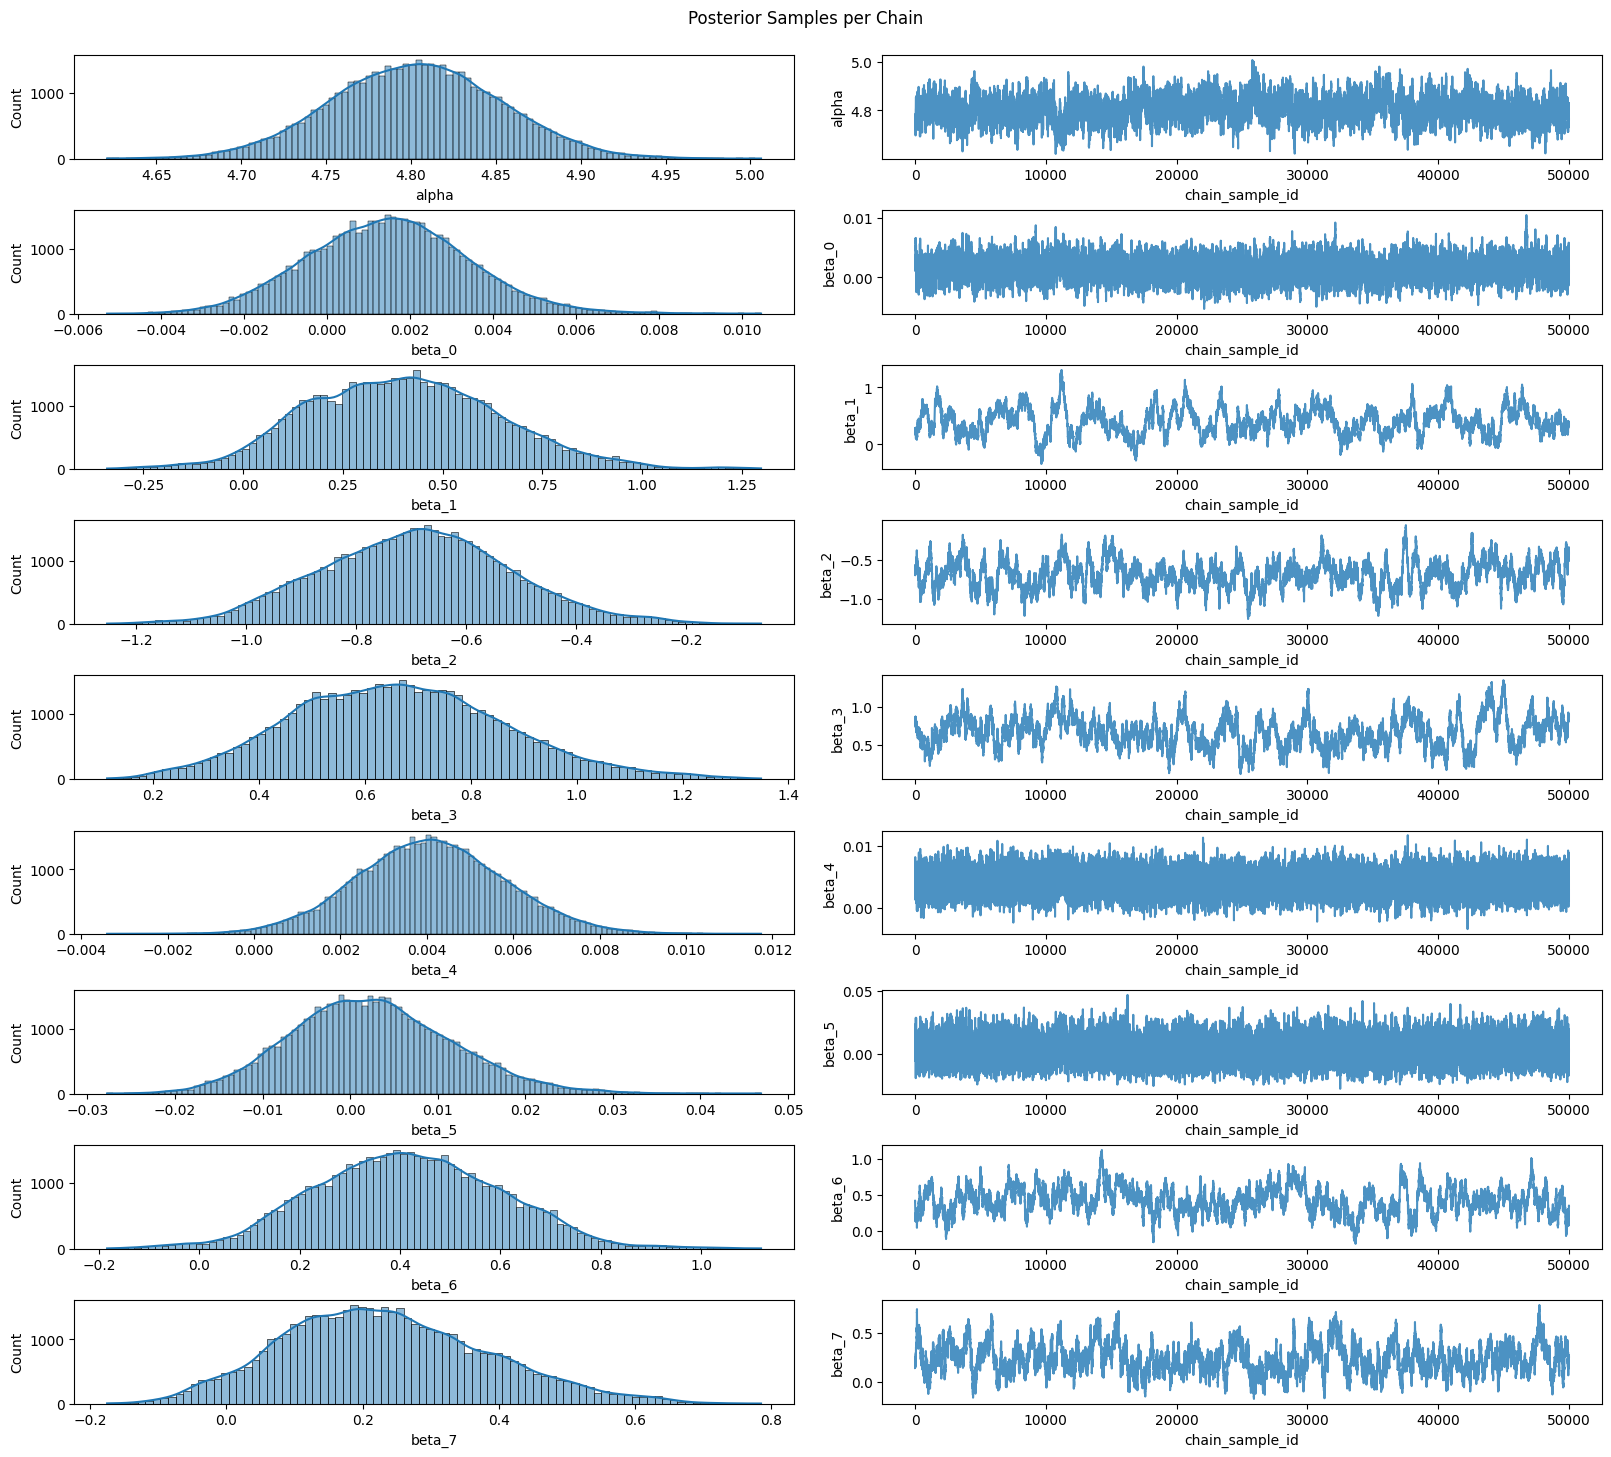

In [301]:
fig, axes = plt.subplots(nrows=len(params), ncols=2, figsize=(16, 14), constrained_layout=True)

for i, param in enumerate(params):
    sns.histplot(x=param, data=chains_df, hue='chain_id', kde=True, ax=axes[i][0], legend=False)
    sns.lineplot(x='chain_sample_id', y=param, data=chains_df, hue='chain_id', alpha=0.8, legend=False, ax=axes[i][1])

fig.suptitle('Posterior Samples per Chain', y=1.03)

Text(0.5, 1.03, 'Posterior Samples')

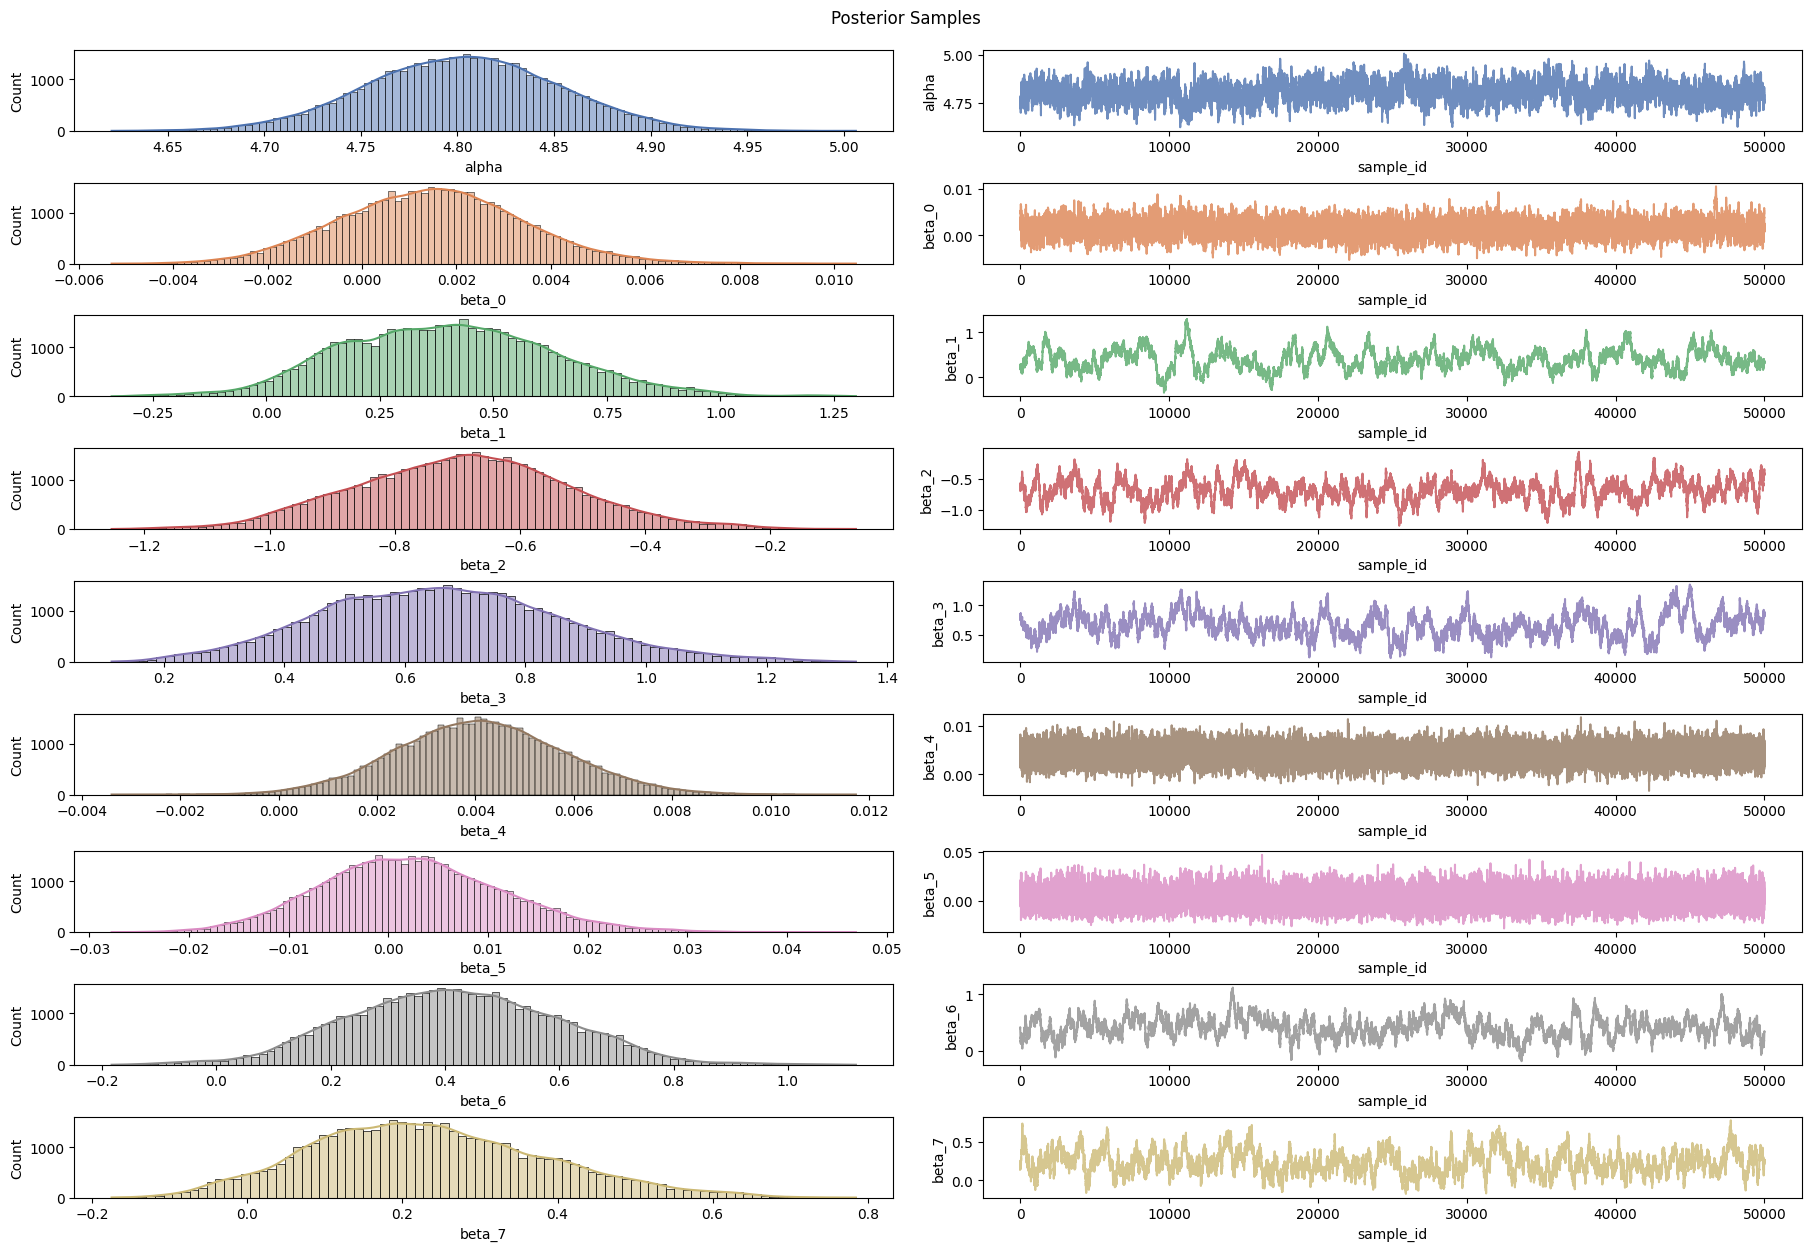

In [302]:
sns_c = sns.color_palette(palette='deep')

fig, axes = plt.subplots(nrows=len(params), ncols=2, figsize=(18, 12), constrained_layout=True)

for i, param in enumerate(params):
    sns.histplot(x=param, data=chains_df, color=sns_c[i], kde=True, ax=axes[i][0])
    sns.lineplot(x='sample_id', y=param, data=chains_df, color=sns_c[i], alpha=0.8, ax=axes[i][1])

fig.suptitle('Posterior Samples', y=1.03)

In [303]:
size = 100
x0 = np.random.randn(size)
x1 = np.random.randn(size)
x = np.stack([x0], axis=1)
x = tf.convert_to_tensor(x, dtype=dtype)

In [304]:
# Here we compute mu = alpha + beta x. #TODO: Needs to fit surv analysis exp(alpha +beta*x)
mu_posterior_samples = tf.linalg.matmul(tf.reshape(chains_samples[0], (-1, 1)), tf.ones(shape=(1, x_obs.shape[0]))) \
    + tf.linalg.matmul(tf.reshape(chains_samples[1], (-1, 1)), tf.transpose(x_obs))

NameError: name 'x_obs' is not defined

In [ ]:
mu_posterior_mean = tf.math.reduce_mean(mu_posterior_samples, axis=0).numpy()
mu_posterior_std = tf.math.reduce_std(mu_posterior_samples, axis=0).numpy()

NameError: name 'mu_posterior_samples' is not defined

In [ ]:
random_guess = tf.convert_to_tensor(np.random.uniform(0, 10, size=(len(y_preds), 1)).astype(np.float32))

NameError: name 'y_preds' is not defined

In [ ]:
train_event_set = tf.expand_dims(e_train.astype(np.int32), axis=1)
train_risks_set = tf.convert_to_tensor(_make_riskset(t_train))
y_pred = tf.convert_to_tensor(y_preds.reshape(len(y_preds), 1).astype(np.float32))

NameError: name 'y_preds' is not defined

In [ ]:
mcmc_train_loss = loss_fn(y_true=[train_event_set, train_risks_set], y_pred=y_pred)
random_guess_loss = loss_fn(y_true=[train_event_set, train_risks_set], y_pred=random_guess)
print(f"MCMC loss {mcmc_train_loss}, random: {random_guess_loss}")